# Introduction

![Porto Seguro Auto](https://segurodecarroaqui.com.br/wp-content/uploads/2017/12/sulamerica-seguro-auto.png)

This notebook starts by giving an introduction in the data of Porto Seguro competition.  Then follows with preparing and running few predictive models using cross-validation and stacking and prepares a submission.

The notebook is using elements from the following kernels:
* [Data Preparation and Exploration](https://www.kaggle.com/bertcarremans/data-preparation-exploration) by Bert Carremans.  
* [Steering Whell of Fortune - Porto Seguro EDA](https://www.kaggle.com/headsortails/steering-wheel-of-fortune-porto-seguro-eda) by Heads or Tails  
* [Interactive Porto Insights - A Plot.ly Tutorial](https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial) by Anisotropic 
* [Simple Stacker](https://www.kaggle.com/yekenot/simple-stacker-lb-0-284) by Vladimir Demidov




# Analysis packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)

C:\Program_Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load the data

In [6]:
trainset = pd.read_csv('../input/train.csv')
testset = pd.read_csv('../input/test.csv')

# Few quick observations

We can make few observations based on the data description in the competition:
* Few **groups** are defined and features that belongs to these groups include patterns in the name (ind, reg, car, calc). The **ind** indicates most probably **individual**, **reg** is probably **registration**, **car** is self-explanatory, **calc** suggests a **calculated** field;
* The postfix **bin** is used for binary features; 
* The postfix **cat** to  is used for categorical features;
* Features without the **bin** or **cat** indications are real numbers (continous values) of integers (ordinal values);
* A missing value is indicated by **-1**;
* The value that is subject of prediction is in the **target** column. This one indicates whether or not a claim was filed for that insured person;
* **id** is a data input ordinal number.

Let's glimpse the data to see if these interpretations are confirmed.

In [7]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


Indeed, we can observe the **cat** values are **categorical**, integer values ranging from **0** to **n**, **bin** values are **binary** (either 0 or 1).

Let's see how many rows and columns are in the data.

In [8]:
print("Train dataset (rows, cols):",trainset.shape, "\nTest dataset (rows, cols):",testset.shape)

Train dataset (rows, cols): (595212, 59) 
Test dataset (rows, cols): (892816, 58)


There are *59* columns in the training dataset and only *58* in the testing dataset. Since from this dataset should have been extracted the **target**, this seems fine. Let's check the difference between the columns set in the two datasets, to make sure everything is fine.

In [9]:
print("Columns in train and not in test dataset:",set(trainset.columns)-set(testset.columns))


Columns in train and not in test dataset: {'target'}


# Introduction of metadata

To make easier the manipulation of data, we will associate few meta-information to the variables in the trainset. This will facilitate the selection of various types of features for analysis, inspection or modeling. We are using as well a **category** field for the `car`, `ind`, `reg` and `calc` types of features.

What metadata will be used:

* **use**: input, ID, target
* **type**: nominal, interval, ordinal, binary
* **preserve**: True or False
* **dataType**: int, float, char
* **category**: ind, reg, car, calc   


In [10]:
# uses code from https://www.kaggle.com/bertcarremans/data-preparation-exploration (see references)
data = []
for feature in trainset.columns:
    # Defining the role
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
         
    # Defining the type
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == float or isinstance(trainset[feature].dtype, float):
        type = 'real'
    elif trainset[feature].dtype == int:
        type = 'integer'
        
    # Initialize preserve to True for all variables except for id
    preserve = True
    if feature == 'id':
        preserve = False
    
    # Defining the data type 
    dtype = trainset[feature].dtype
    
    category = 'none'
    # Defining the category
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
    
    
    # Creating a Dict that contains all the metadata for the variable
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category' : category
    }
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,binary,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,categorical,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


We can extract, for example, all categorical values:

In [11]:
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11'],
      dtype='object', name='varname')

Let's inspect all features, to see how many category distinct values do we have:

In [12]:
pd.DataFrame({'count' : metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registration,3


We have 20 *calculated* features, 16 *car*, 18 *individual* and 3 *registration*.

Let's inspect now all features, to see how many use and type distinct values do we have:

In [13]:
pd.DataFrame({'count' : metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,20
2,input,categorical,16
3,input,real,21
4,target,binary,1


There are one nominal feature (the **id**), 20 binary values, 21 real (or float numbers), 16 categorical features - all these being as well **input** values and one **target** value, which is as well **binary**, the **target**.

# Data analysis and statistics



## Target variable

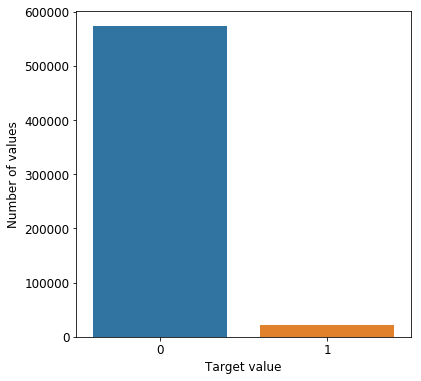

In [14]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
x = trainset['target'].value_counts().index.values
y = trainset["target"].value_counts().values
# Bar plot
# Order the bars descending on target mean
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

Only 3.64% of the target data have 1 value. This means that the training dataset is highly imbalanced. We can either undersample the records with target = 0 or oversample records with target = 1; because is a large dataset, we will do undersampling of records with target = 0.

## Real features

In [15]:
variable = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[variable].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


In [16]:
(pow(trainset['ps_car_12']*10,2)).head(10)


0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [17]:
(pow(trainset['ps_car_15'],2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

### Features with missing values

**ps_reg_o3**, **ps_car_12**, **ps_car_14** have missing values (their minimum value is -1)


### Registration features

**ps_reg_01** and **ps_reg_02** are fractions with denominator 10 (values of 0.1, 0.2, 0.3 )

### Car features

**ps_car_12** are (with some approximations) square roots (divided by 10) of natural numbers whilst **ps_car_15** are square roots of natural numbers. Let's represent the values using *pairplot*.




C:\Program_Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Program_Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


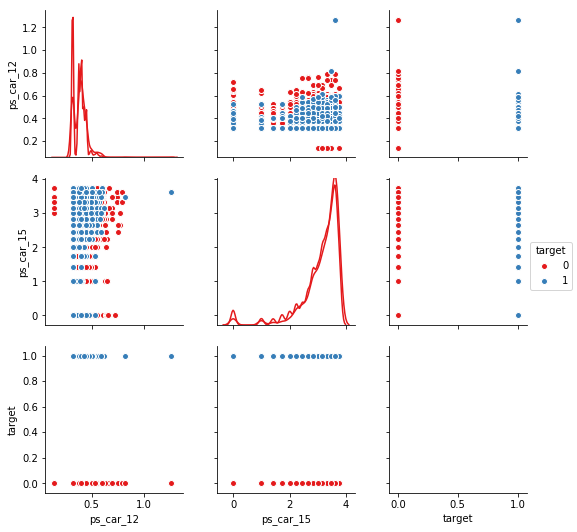

In [18]:
sample = trainset.sample(frac=0.05)
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

### Calculated features

The features **ps_calc_01**, **ps_calc_02** and **ps_calc_03** have very similar distributions and could be some kind of ratio, since the maximum value is for all three 0.9. The other calculated values have maximum value an integer value (5,6,7, 10,12). 

Let's visualize the real features distribution using density plot.

In [21]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3,4,figsize=(16,12))

for feature in var:
    i += 1
    plt.subplot(3,4,i)
    sns.kdeplot(t1[feature], bw=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

ValueError: num must be 1 <= num <= 12, not 13

**ps_reg_02**, **ps_car_13**, **ps_car_15** shows the most different distributions between sets of values associated with `target=0` and `target=1`.

Let's visualize the correlation between the real features

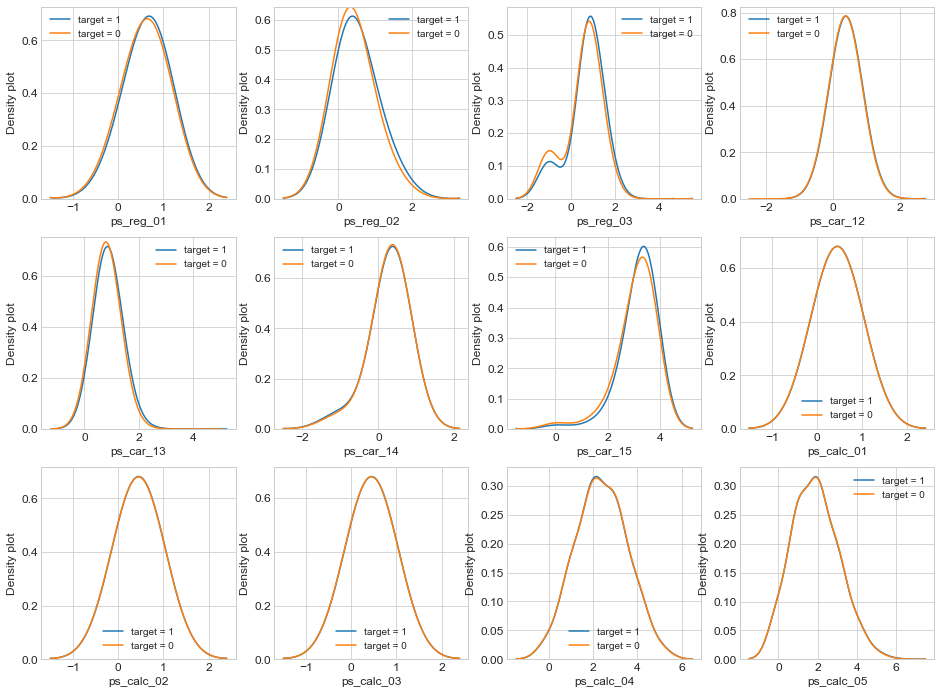

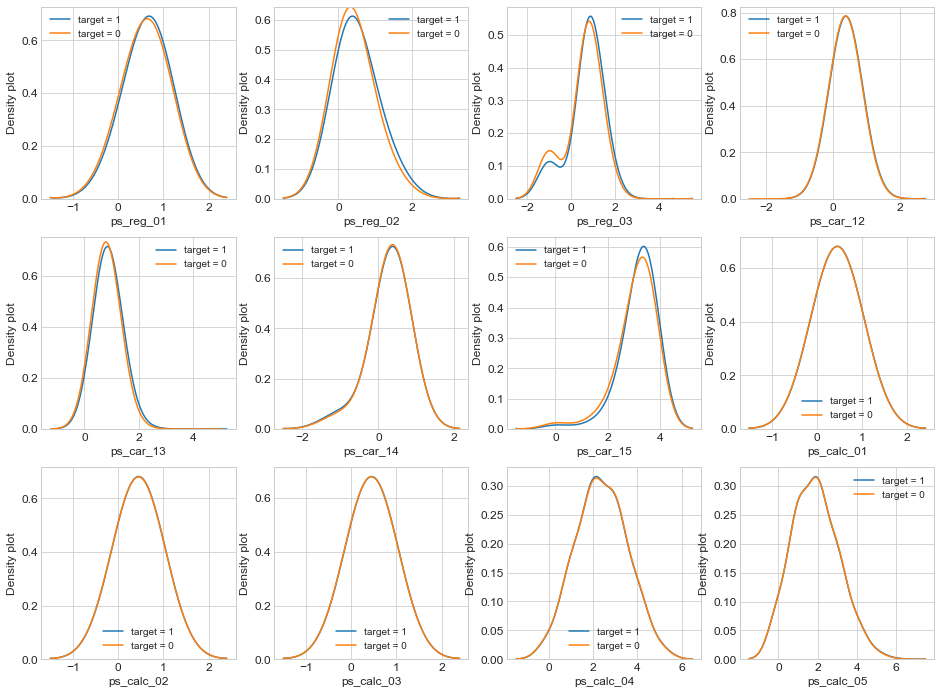

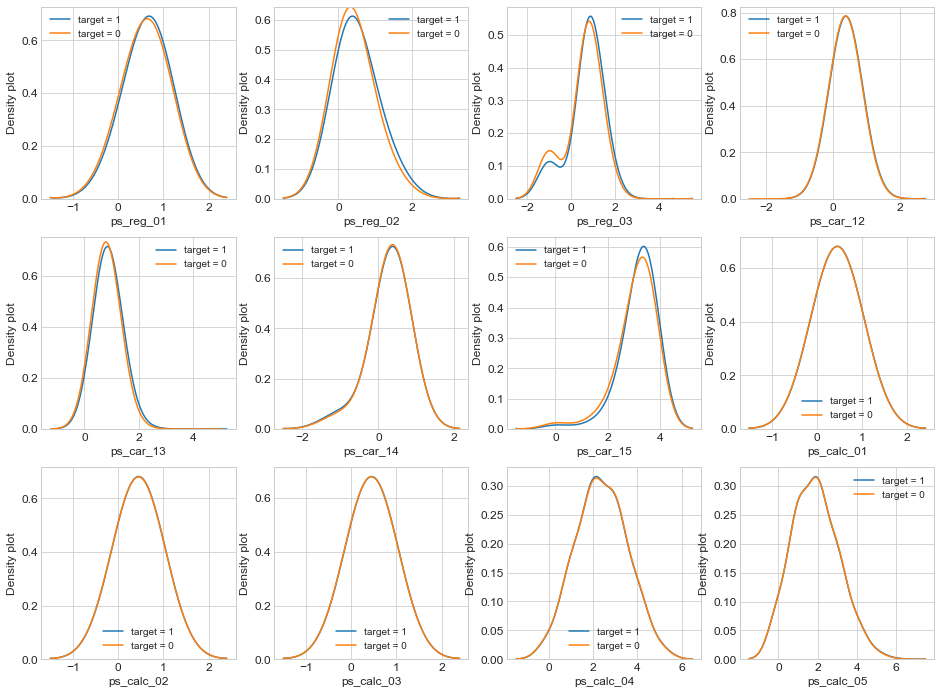

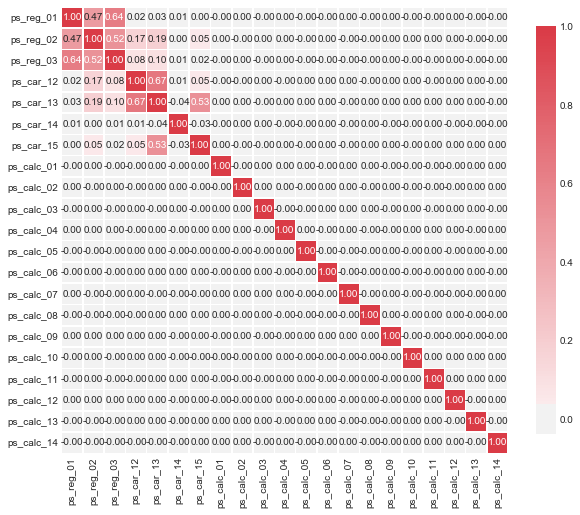

In [22]:
def corr_heatmap(var):
    correlations = trainset[var].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(50, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)

Let's visualize the plots of the variables with strong correlations. These are:

* ps_reg_01 with ps_reg_02 (0.47);  
* ps_reg_01 with ps_reg_03 (0.64);  
* ps_reg_02 with ps_reg_03 (0.52);  
* ps_car_12 with ps_car_13 (0.67);  
* ps_car_13 with ps_car_15 (0.53);  


To show the pairs of values that are correlated we use *pairplot*. Before representing the pairs, we subsample the data, using only 2% in the sample.



C:\Program_Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Program_Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


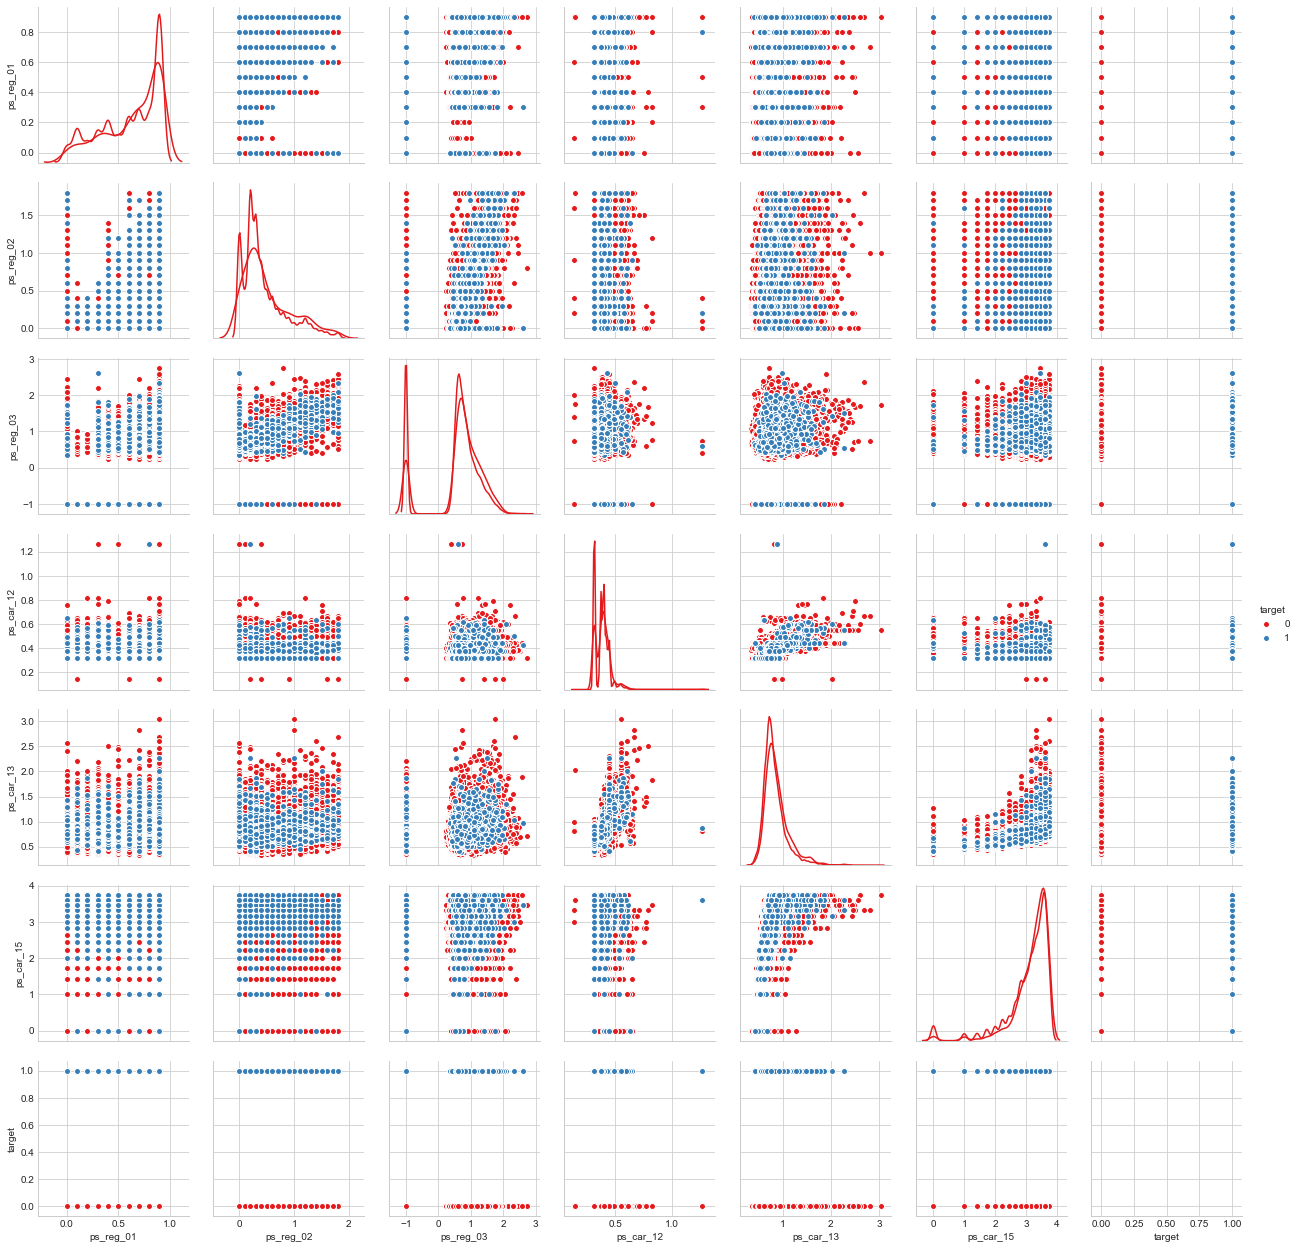

In [19]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample,  hue='target', palette = 'Set1', diag_kind='kde')
plt.show()

# Binary features



In [25]:

v = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[v].describe()

,target,ps_ind_01,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.012451,7.299922,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.127545,3.546042,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
v

Index(['target', 'ps_ind_01', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='object', name='varname')

Let's plot the distribution of the binary data in the training dataset. With `blue` we represent the percent of `0` and with `red` the percent of `1`.

C:\Program_Files\Anaconda3\lib\site-packages\matplotlib\legend.py:634: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x000001CF15E451D0> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


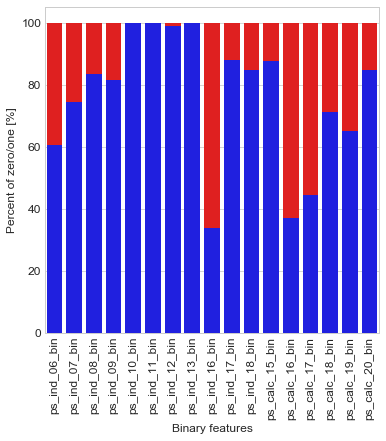

In [23]:
bin_col = [col for col in trainset.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((trainset[col]==0).sum()/trainset.shape[0]*100)
    one_list.append((trainset[col]==1).sum()/trainset.shape[0]*100)
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
# Bar plot
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color="blue")
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom= zero_list, color="red")
plt.ylabel('Percent of zero/one [%]', fontsize=12)
plt.xlabel('Binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('Zero', 'One'))
plt.show();

**ps_ind_10_bin**, **ps_ind_11_bin**, **ps_ind_12_bin** and **ps_ind_13_bin** have very small number of  values `1` (lesss than 0.5%) whilst the number of  value `1` is very large for **ps_ind_16_bin** and **ps_cals_16_bin** (more than 60%).

Let's see now the distribution of binary data and the corresponding values of **target** variable.


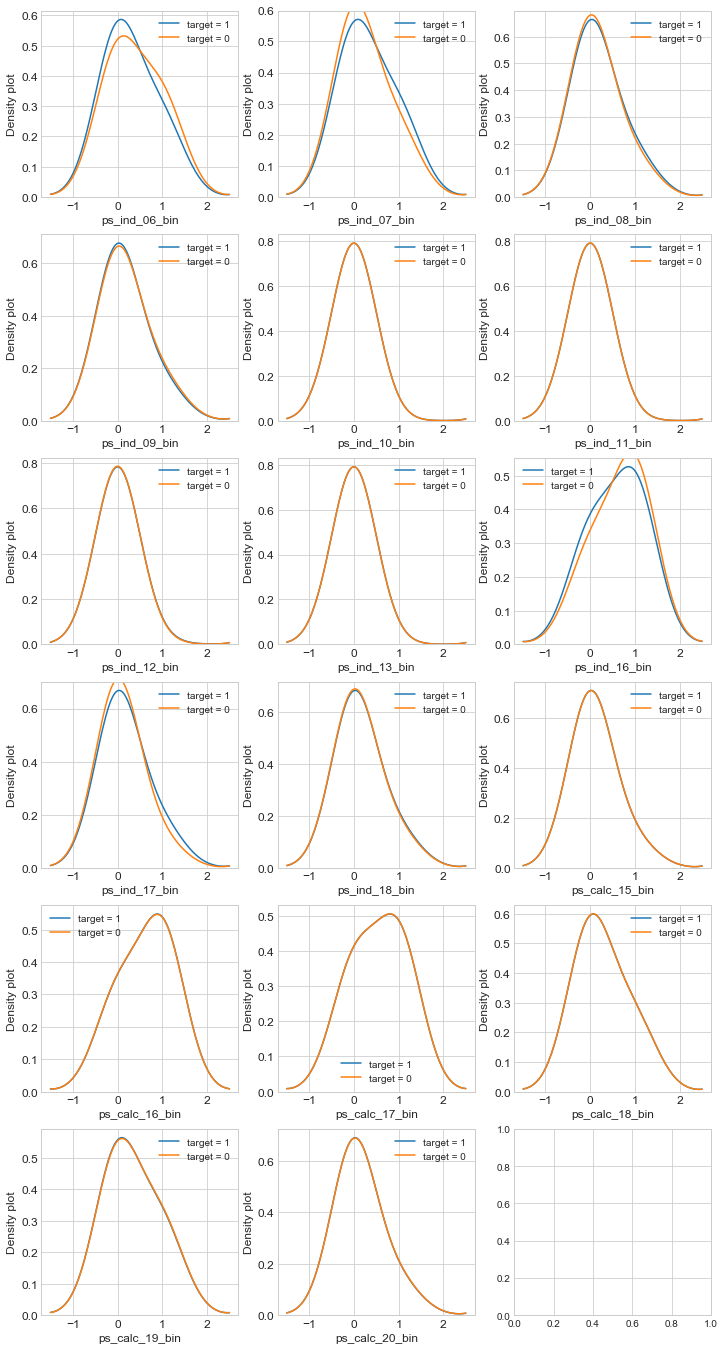

In [22]:
var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
var = [col for col in trainset.columns if '_bin' in col]
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(6,3,figsize=(12,24))

for feature in var:
    i += 1
    plt.subplot(6,3,i)
    sns.kdeplot(t1[feature], bw=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

**ps_ind_06_bin**, **ps_ind_07_bin**, **ps_ind_16_bin**, **ps_ind_17_bin**  shows high inbalance between distribution of values of `1` and `0` for values of target equals with `1` and `0`, **ps_ind_08_bin** shows a small inbalance while the other features are well balanced, having similar density plots.

## Categorical features

We will represent the distribution on `categorical` data in two ways. 
First, we calculate the percentage of `target=1` per category value and represent these percentages
using bar plots.

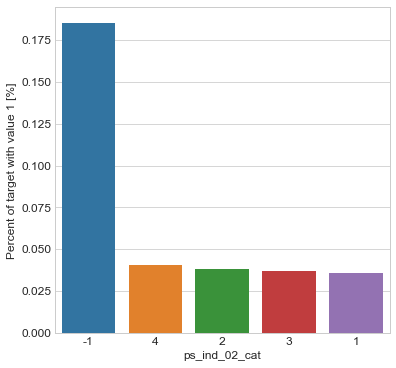

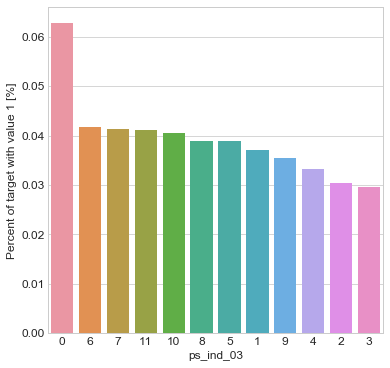

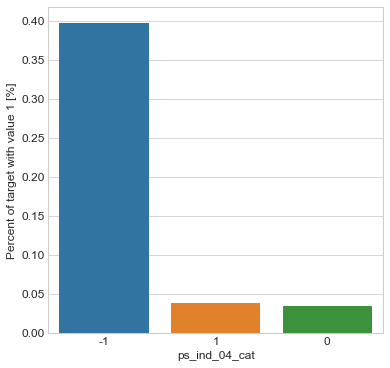

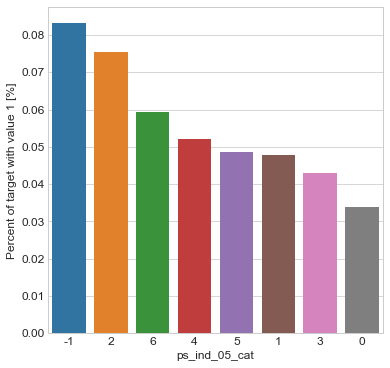

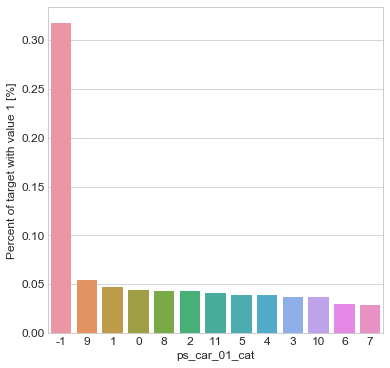

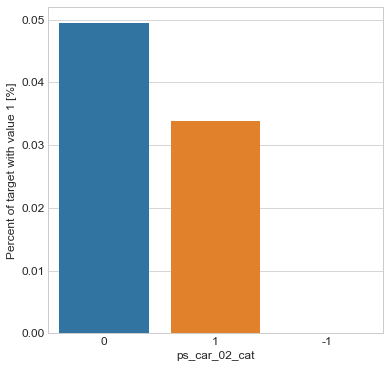

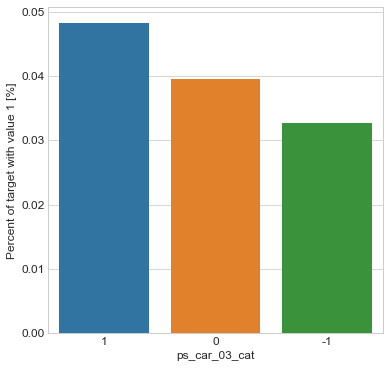

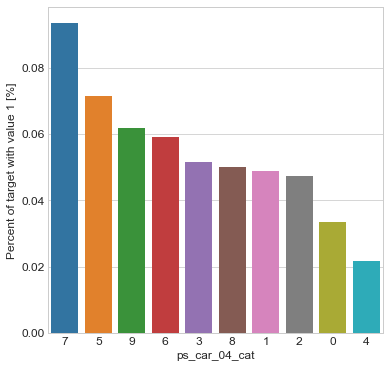

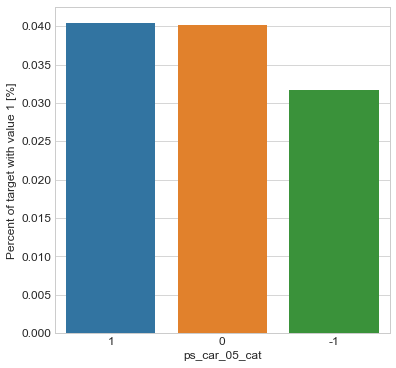

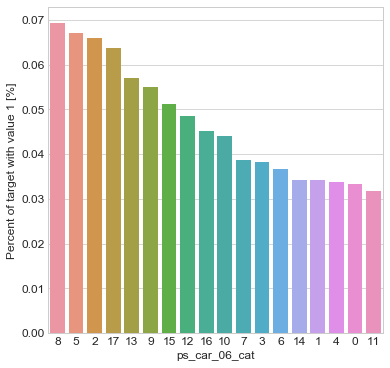

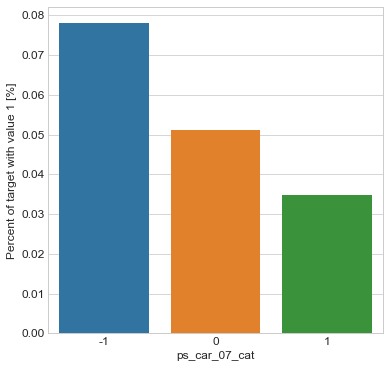

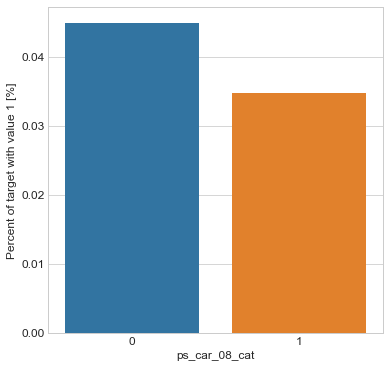

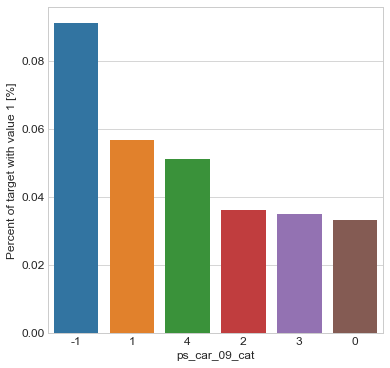

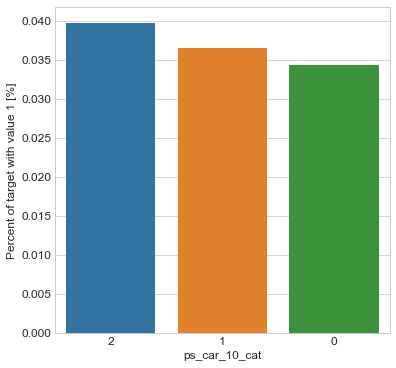

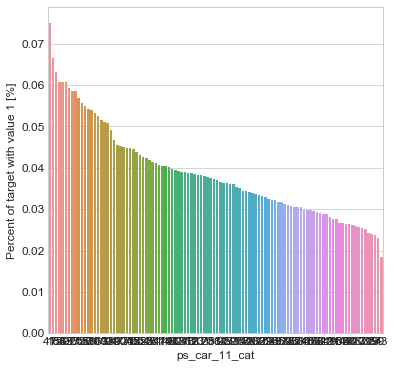

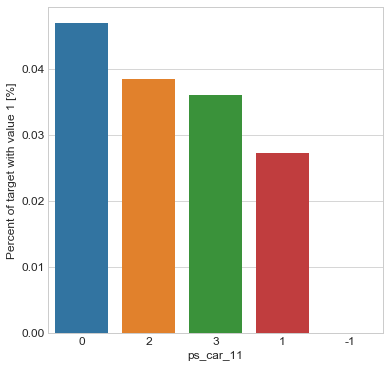

In [23]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

for feature in var:
    fig, ax = plt.subplots(figsize=(6,6))
    # Calculate the percentage of target=1 per category value
    cat_perc = trainset[[feature, 'target']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax,x=feature, y='target', data=cat_perc, order=cat_perc[feature])
    plt.ylabel('Percent of target with value 1 [%]', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

Alternativelly we represent the `categorical` features using density plot. We select values with `target=0` and `target=1` and represent both density plots on the same graphic.

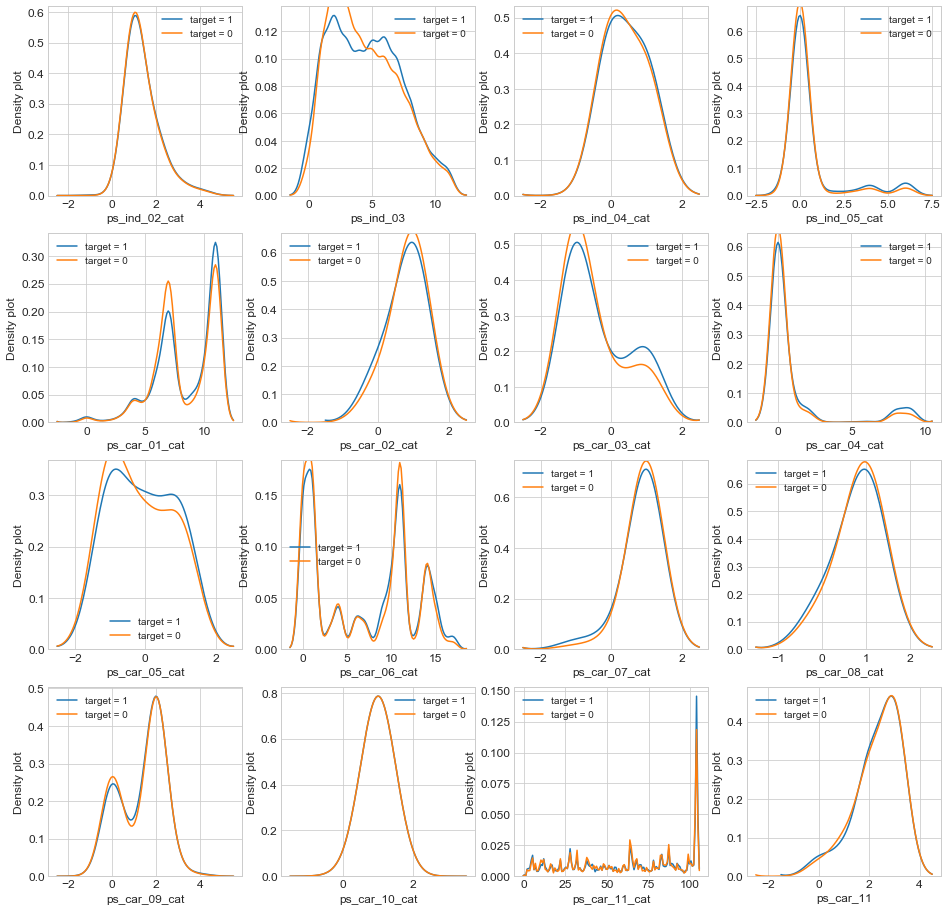

In [24]:
var = metadata[(metadata.type == 'categorical') & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset['target'] != 0]
t0 = trainset.loc[trainset['target'] == 0]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(4,4,figsize=(16,16))

for feature in var:
    i += 1
    plt.subplot(4,4,i)
    sns.kdeplot(t1[feature], bw=0.5,label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5,label="target = 0")
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

**ps_car_03_cat**, **ps_car_05_cat** shows the most different density plot between values associated with `target=0` and `target=1`.

## Data unbalance between train and test data 

Let's compare the distribution of the features in the train and test datasets. 

We start with the `reg` or `registration` features.

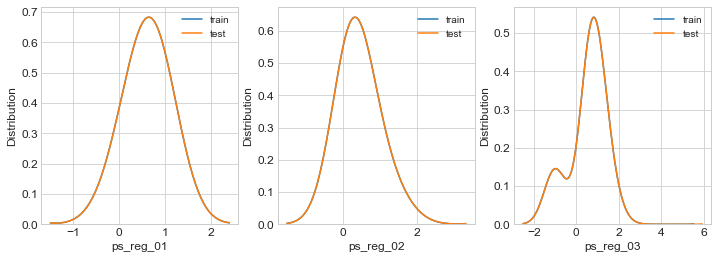

In [25]:
var = metadata[(metadata.category == 'registration') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(1,3,figsize=(12,4))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(1,3,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

All `reg` features shows well balanced train and test sets.

Let's continue with `car` features.

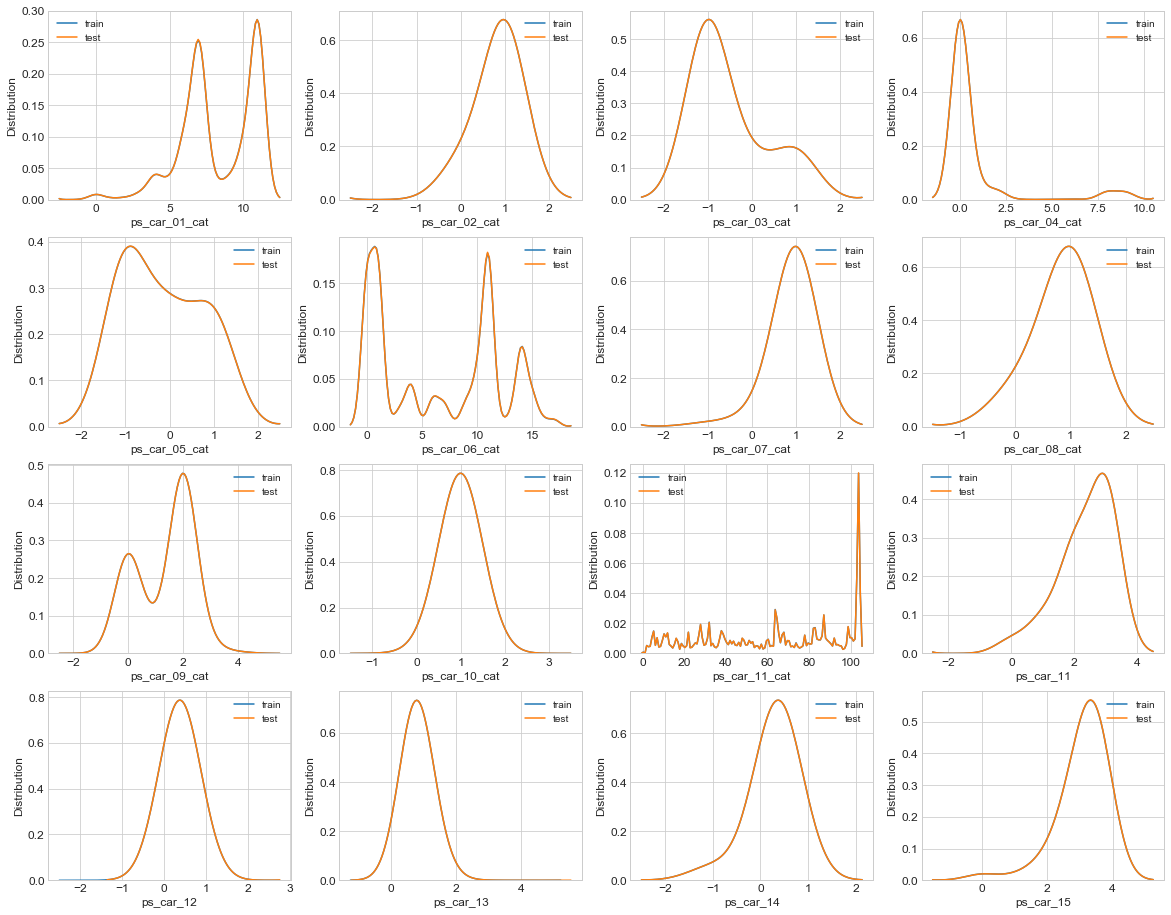

In [26]:
var = metadata[(metadata.category == 'car') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(4,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(4,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

From the `car` features, all variables looks well balanced between `train` and `test` set.

Let's look now to the `ind` (`individual`) values.

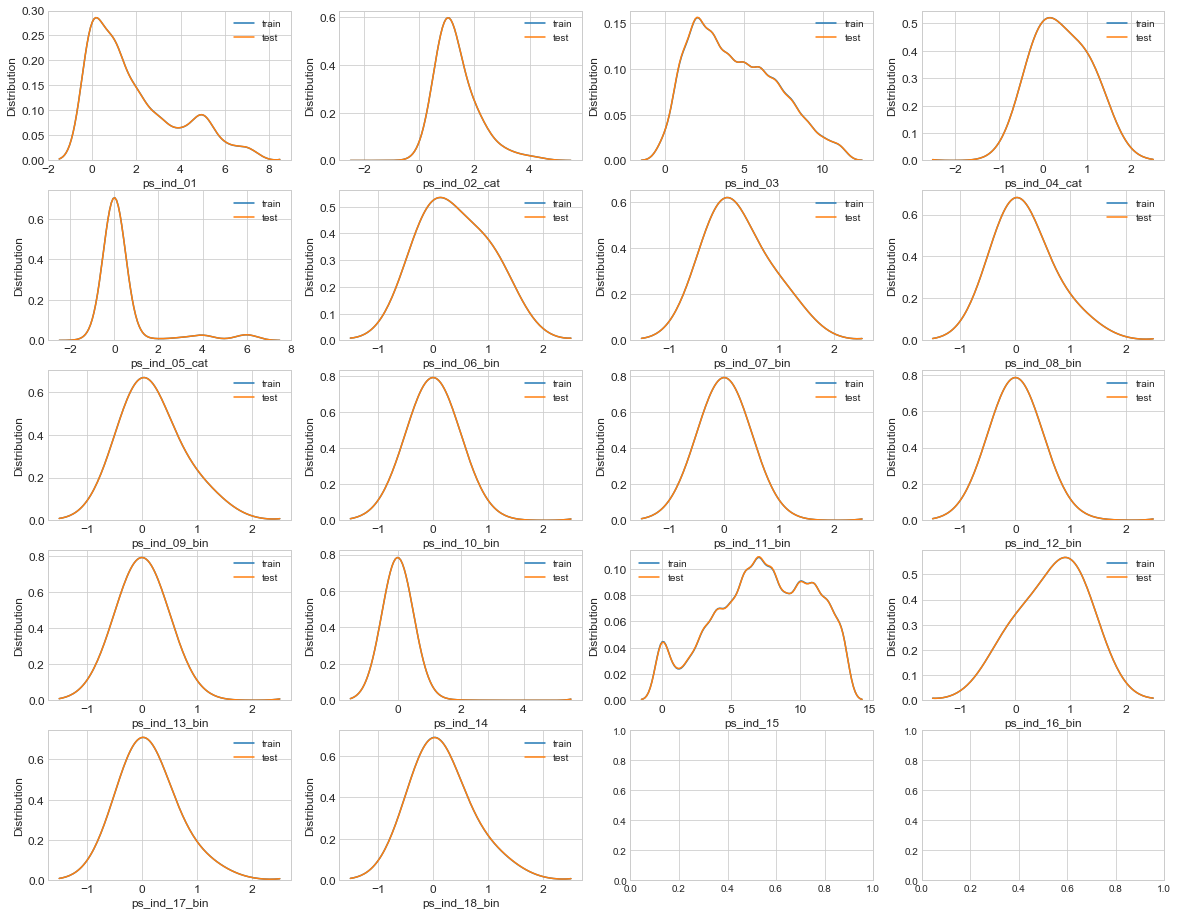

In [27]:
var = metadata[(metadata.category == 'individual') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

All `ind` features are well balanced between `train` and `test` sets.

Let's check now `calc` features.

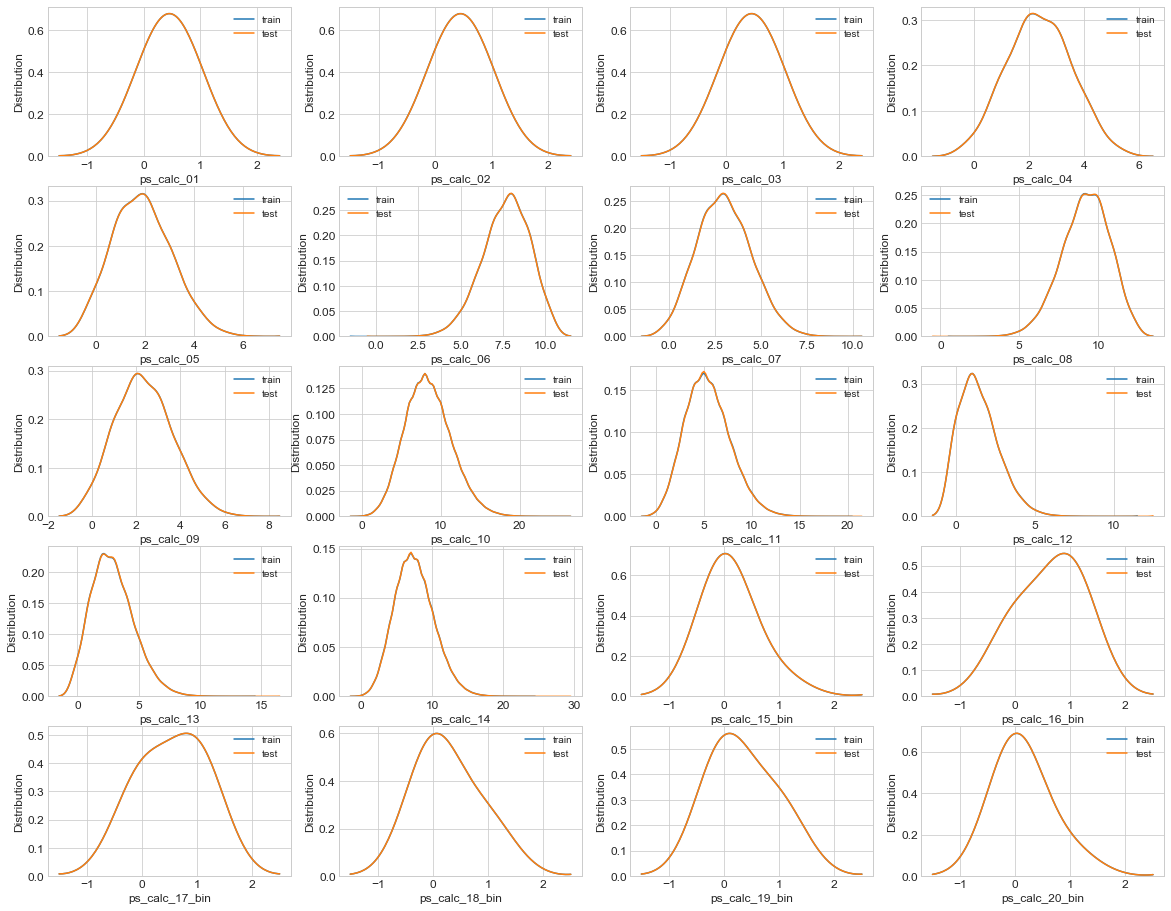

In [28]:
var = metadata[(metadata.category == 'calculated') & (metadata.preserve)].index

# Bar plot
sns.set_style('whitegrid')

plt.figure()
fig, ax = plt.subplots(5,4,figsize=(20,16))
i = 0
for feature in var:
    i = i + 1
    plt.subplot(5,4,i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel('Distribution', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    #plt.setp(labels, rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

All `calc` features are well balanced between `train` and `test` sets. 

In reference [5] it is also noticed the well balancing between `train` and `test` sets. It is also suggested that `calc` features might be all engineered and actually not relevant. This can only be assesed by careful succesive elimination using `CV` score using one or more predictive models.



# Check data quality

Let's inspect the features with missing values:

In [29]:
vars_with_missing = []

for feature in trainset.columns:
    missings = trainset[trainset[feature] == -1][feature].count()
    if missings > 0:
        vars_with_missing.append(feature)
        missings_perc = missings/trainset.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(feature, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


# Prepare the data for model


### Drop unused and **target** columns

We separate the **id** and **target** (drop these columns)


In [30]:
id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target','id'], axis = 1)
testset = testset.drop(['id'], axis = 1)

### Drop **calc** columns

We also drop the **calc** columns, as recommended in [5]. These seems to be all engineered and, according to Dmitry Altukhov, he was able to improve his CV score while succesivelly removing all of them.


In [31]:
col_to_drop = trainset.columns[trainset.columns.str.startswith('ps_calc_')]
trainset = trainset.drop(col_to_drop, axis=1)  
testset = testset.drop(col_to_drop, axis=1)  

### Replace **-1** values with NaN

Most of the classifiers we would use have preety good strategies to manage missing (or NaN) values.


In [32]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

### Dummify **cat** values

We will create dummy variables for the **categorical** (**cat**) features


In [33]:
cat_features = [a for a in trainset.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset,temp],axis=1)
    trainset = trainset.drop([column],axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset,temp],axis=1)
    testset = testset.drop([column],axis=1)

Let's inspect the training and test sets:

In [34]:
print("Train dataset (rows, cols):",trainset.values.shape, "\nTest dataset (rows, cols):",testset.values.shape)

Train dataset (rows, cols): (595212, 198) 
Test dataset (rows, cols): (892816, 198)



# Prepare the model

### Ensable class for cross validation and ensamble

Prepare an **Ensamble** class to split the data in KFolds, train the models and ensamble the results.

The class has an **init** method (called when an Ensamble object is created) that accepts 4 parameters:

* **self** - the object to be initialized  
* **n_splits** - the number of cross-validation splits to be used  
* **stacker** - the model used for stacking the prediction results from the trained base models    
* **base_models** - the list of base models used in training  

A second method, **fit_predict** has four functions:
* split the training data in **n_splits** folds;  
* run the **base models** for each fold;  
* perform prediction using each model;  
* ensamble the resuls using the **stacker**;  




In [35]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=2016).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]


                print ("Base model %d: fit %s model | fold %d" % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        # Calculate gini factor as 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

### Parameters for the base models

For the base models, we prepare three different LightGBM models. 

Each model is used to train the data (using as well cross-validation, with 3 folds).


In [36]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8   
lgb_params1['min_child_samples'] = 500
lgb_params1['random_state'] = 314

# lgb2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['random_state'] = 314

# lgb3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['random_state'] = 314



### Initialize the models with the parameters

We init the 3 base models and the stacking model. For the base models we are using the predefined parameters initialized above.



In [37]:
# Base models
lgb_model1 = LGBMClassifier(**lgb_params1)

lgb_model2 = LGBMClassifier(**lgb_params2)
       
lgb_model3 = LGBMClassifier(**lgb_params3)

# Stacking model
log_model = LogisticRegression()

### Initialize the ensambling object

Using Ensamble.init we init the stacking object


In [38]:
stack = Ensemble(n_splits=3,
        stacker = log_model,
        base_models = (lgb_model1, lgb_model2, lgb_model3))  

# Run the predictive models


Calling the **fit_predict** method of **stack** object, we run the training of the base models, predict the **target** with each model, ensamble the results using the **stacker** model and output the stacked result.


In [39]:
y_prediction = stack.fit_predict(trainset, target_train, testset)        

Base model 1: fit LGBMClassifier model | fold 1
Base model 1: fit LGBMClassifier model | fold 2
Base model 1: fit LGBMClassifier model | fold 3
Base model 2: fit LGBMClassifier model | fold 1
Base model 2: fit LGBMClassifier model | fold 2
Base model 2: fit LGBMClassifier model | fold 3
Base model 3: fit LGBMClassifier model | fold 1
Base model 3: fit LGBMClassifier model | fold 2
Base model 3: fit LGBMClassifier model | fold 3
Stacker score [gini]: 0.28519


### Prepare the submission

In [70]:
submission = pd.DataFrame()
submission['id'] = id_test
submission['target'] = y_prediction
submission.to_csv('stacked.csv', index=False)

# References

[1] Porto Seguro Safe Driver Prediction, Kaggle Competition, https://www.kaggle.com/c/porto-seguro-safe-driver-prediction   
[2] Bert Carremans, Data Preparation and Exploration, Kaggle Kernel, https://www.kaggle.com/bertcarremans/data-preparation-exploration   
[3] Head or Tails, Steering Whell of Fortune - Porto Seguro EDA, Kaggle Kernel, https://www.kaggle.com/headsortails/steering-wheel-of-fortune-porto-seguro-eda   
[4] Anisotropic, Interactive Porto Insights - A Plot.ly Tutorial, Kaggle Kernel, https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial  
[5] Dmitry Altukhov, Kaggle Porto Seguro's Safe Driver Prediction (3rd place solution),  https://www.youtube.com/watch?v=mbxZ_zqHV9c  
[6] Vladimir Demidov, Simple Staker LB 0.284, https://www.kaggle.com/yekenot/simple-stacker-lb-0-284  
[7] Anisotropic, Introduction to Ensembling/Stacking in Python, https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python  





# Feedback

I will appreciate your suggestions and observations.